# Purpose of this code

We want to estimate the number of solutions to a 3-SAT problem using quantum phase estimation.

The answer can allow us to search with appropriate iterations using the Grover algorithm.

The search, upon final measurement, would return with high probability a solution to the 3-SAT problem.

## 3-SAT problem

A 3-SAT problem is located in a file called "sat_example.cnf". We must first load in the file, read the lines of data, and parse it into a usable form for our quantum circuit.

## Imports and Functions

In [1]:
# Imports
from qiskit import (QuantumRegister, ClassicalRegister, QuantumCircuit,
                    execute, transpile, BasicAer)
from qiskit.visualization import plot_histogram
import numpy as np

In [2]:
def read_cnf(file:str):
    """
    Load and read a CNF file, then return the clauses as well as the number of literals and number of clauses:
    - nbvar = # of literals
    - nbclauses = # of clauses
    - storage = list of clauses
    """

    storage = []

    with open(file, "r") as fr:
        for line in fr.readlines():
            if line[0] == "c" :
                pass
            elif line[0] == "p" :
                arg_list = line.split(" ")
                nbvar = int(arg_list[2])
                nbclauses = int(arg_list[3].strip())
            else:
                lit_list = line.split(" ", maxsplit=3)
                lit_list.__delitem__(-1)
                lit_list = [int(element) for element in lit_list]
                lit_list.sort()
                storage.append(lit_list)
        
    return(storage, nbvar, nbclauses)

In [3]:
def clause_oracle(circuit:QuantumCircuit, clause:list) -> QuantumCircuit:
    """
    Create oracle for a single 3-SAT clause. Return a Quantum Circuit with attached oracle.
    - oracle = quantum circuit (input) with attached oracle (output)
    """
    oracle = circuit
    array = np.unique(np.array(clause))
    
    # Apply X gates to the positive literals
    for literal in array:
        if literal > 0:
            oracle.x(circuit.qubits[circuit.num_qubits - literal]) 
    
    # Anti- / Negated- MCX
    oracle.x(circuit.qubits[0:])
    oracle.h(circuit.qubits[-1])
    oracle.mcx(circuit.qubits[0:-1], circuit.qubits[-1])
    oracle.h(circuit.qubits[-1])
    oracle.x(circuit.qubits[0:])

    # Apply X gates to the positive literals
    for literal in array:
        if literal > 0:
            oracle.x(circuit.qubits[circuit.num_qubits - literal]) 
    
    return oracle

In [4]:
def diffuser(circuit:QuantumCircuit) -> QuantumCircuit:
    """
    Create diffuser circuit for Grover search. Returns Quantum Circuit with attached diffuser.
    - diffuser = quantum circuit (input) with attached diffuser (output)
    """
    diffuser = circuit
    
    diffuser.h(circuit.qubits[0:])
    diffuser.x(circuit.qubits[0:])
    diffuser.h(circuit.qubits[-1])

    diffuser.mcx(circuit.qubits[0:-1],circuit.qubits[-1])

    diffuser.h(circuit.qubits[-1])
    diffuser.x(circuit.qubits[0:]) 
    diffuser.h(circuit.qubits[0:])
    
    return diffuser

In [5]:
# Defining the Inverse QFT for the first register

def iQFT(circuit:QuantumCircuit) -> QuantumCircuit:
    """
    Create inverse Quantum Fourier Transform circuit based on the number of input qubits.
    First builds Quantum Fourier Transform, then inverses the circuit operations.
    - circuit = returned circuit with inverse Fourier Transform
    """
    number_qb = circuit.num_qubits

    QFT = QuantumCircuit(number_qb)
    
    # # # QFT for loop # # #
    for i in range(number_qb):
        
        # Start with H on bottom control qubit
        QFT.h(number_qb - (1 + i))

        # For loop with rotation angles
        for j in range(number_qb - (1 + i)):
            
            rotation = (2 * np.pi) / 2**(2 + j)

            # The controlled rotation
            QFT.cu(theta=0, phi=rotation, lam=0, gamma=0,
                control_qubit=(number_qb-(1+i)-(1+j)), target_qubit=(number_qb-(1+i)))

    # # # SWAPS # # #
    [QFT.swap(qb, number_qb - (1 + qb)) for qb in range(number_qb//2)]

    iQFT = QFT.inverse().to_gate(label="iQFT")
    circuit.append(iQFT, range(number_qb))

    return circuit

In [6]:
# Path to CNF file
sat_example_file = "/Users/matthewkegley/Documents/MyCodingProjects/python/qiskit/JHU_QIP_Course_Assignments/Final Project/sat_problems/cnf_files/sat_example.cnf"

# SAT clauses
(cnf_storage, nbvar, nbclauses) = read_cnf(sat_example_file)

print("The number of literals: " + str(nbvar), "The number of clauses: " + str(nbclauses))

# Circuit Registers
We have loaded the CNF file into a Python list. The registers for the phase estimation are based on the Quantum Fourier Transform (QFT) and Grover search algorithms.

## First Quantum Register
The first register holds the controls of the phase estimation algorithm, and outputs a phase - a numeric determining the number of solutions to the SAT problem - when measured.
The phase is outputted to an accuracy of $m$ qubits with a probability of $1-\varepsilon$.

To obtain this probability and accuracy, the total number of qubits needed for the estimation is:

$ \begin{equation}
t = m + \left\lceil \log \left( 2 + \frac{1}{2\varepsilon} \right) \right\rceil
\end{equation} $

An accuracy to $m$ bits means the phase will be reported at least to a decimal value of $2^{-m}$. 
We can say we desire an accuracy to $\dfrac{1}{2^{5}} = 0.03125 \approx 0.03$ where we have set $m=5$ qubits.

To guarantee a high probability of measuring the accurate phase, we set the probability of failure $\varepsilon$ to be $\dfrac{1}{6}$, such that $1-\varepsilon = \dfrac{5}{6} = 0.83$. 

Then the number of qubits needed for $83\%$ success and $5$-qubit accuracy is:

$ \begin{equation}
t = 5 + \left\lceil \log \left( 2 + \frac{1}{2(1/6)} \right) \right\rceil = 5 + \left\lceil 2.32 \right\rceil = 8
\end{equation} $

In [7]:
# Create first quantum register with 8 qubits and classical readout register

# Specify number of readout qubits
readout = 8

# Specify readout registers
controls = QuantumRegister(readout,"controls")
phase_result = ClassicalRegister(readout,"phase_result")

## Second Quantum Register
The second register holds the targets of the phase estimation algorithm. Here, we apply the Grover iteration $G = \left(2|\psi\rangle\langle\psi| - \hat{I} \right) \hat{O}$ substituted in for the general unitary $\hat{U}$. 

The number of qubits in the register is determined by the search space. Since the CNF file includes four literals, we need four qubits to represent them, spanning a search space of $N = 2^{4} = 16$ items. 

In [8]:
# Create second quantum register with 4 qubits
targets = QuantumRegister(nbvar, "targets")

# Combine registers into a quantum circuit
qc_phase = QuantumCircuit(controls, targets, phase_result)

### 3-SAT Oracle and Diffuser

The 3-SAT Oracle marks the solutions for the 3-SAT problem. It does this by using ancillas to identify states that *do not* satisfy a particular clause. 
The reasoning is that given a clause of three literals, if any one literal is TRUE, then the whole clause is TRUE. 

Instead of going through cases that satisfy the clause, we look at just the single case that *doesn't* satisfy the clause to then flip an ancilla.

For example, looking at this 2-SAT problem:

$\begin{equation}
\left( x_0 \lor x_1 \right) \land \left( x_0 \lor \lnot x_1 \right)
\end{equation}$

The first clause is unsatisfied when both $x_0$ and $x_1$ are FALSE. The second clause is unsatisfied when $x_0$ is FALSE and $x_1$ is TRUE. 

Taking these values into a quantum circuit, two ancillas can be encoded to flip for those unsatisfying cases:

$\begin{equation}
\underbrace{|-\rangle |0 \red 1\rangle}_{ancilla} |00\rangle + 
\underbrace{|-\rangle | \red 10\rangle}_{ancilla} |01\rangle + 
\underbrace{|-\rangle |00\rangle}_{ancilla} |10\rangle + 
\underbrace{|-\rangle |00\rangle}_{ancilla} |11\rangle
\end{equation}$

A negated Toffoli is then applied across the ancillas with $|-\rangle$ as the target.

$\begin{equation}
\begin{align*}
\xrightarrow{\hat{X} \ (ancillas)} \qquad & |-\rangle|10\rangle|00\rangle + |-\rangle|01\rangle|01\rangle + |-\rangle|11\rangle|10\rangle + |-\rangle|11\rangle|11\rangle \\
\xrightarrow{Toffoli} \qquad & |-\rangle|10\rangle|00\rangle + |-\rangle|01\rangle|01\rangle - |-\rangle|11\rangle|10\rangle - |-\rangle|11\rangle|11\rangle \\
\xrightarrow{\hat{X} \ (ancillas)} \qquad & |-\rangle|01\rangle|00\rangle + |-\rangle|10\rangle|01\rangle - |-\rangle|00\rangle|10\rangle - |-\rangle|00\rangle|11\rangle \\
\end{align*}
\end{equation}$

From here, the diffuser now has the correct, marked states of $|10\rangle$ and $|11\rangle$ to amplify.


We continue in this way for each clause, flipping an ancilla for the unsatisfactory state, then performing a negated controlled-NOT over the register.

The negated controlled NOT is surrounded by Hadamards, meaning it acts as a controlled Z gate. 

As it turns out, ancillas aren't necessary for the oracle operation. The phase estimation algorithm utilizes just the database qubits to mark the solutions just as accurately.

### Grover Unitary
Now we build the Grover unitary. We apply an oracle for each clause, marking solution states to the SAT problem. Then we apply the diffuser to amplify their amplitudes.

In [9]:
# GROVER UNITARY

G_gate = QuantumCircuit(targets)

# Apply oracle (for all clauses)
for i in range(nbclauses):
    G_gate = clause_oracle(G_gate, cnf_storage[i])

# Apply diffuser
G_gate = diffuser(G_gate)

# Circuit drawing
G_gate_drawing = G_gate.draw(fold=1000)

# Create controlled-gate form of the Grover iteration
G = G_gate.to_gate(label="G")
cG = G.control(1, label="G") # one control

G_gate_drawing

┌───┐          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐┌───┐     ┌───┐┌───┐┌───┐          ┌───┐┌───┐               ┌───┐┌───┐                    ┌───┐┌───┐                    ┌───┐┌───┐               ┌───┐┌───┐┌───┐               ┌───┐┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐               ┌───┐┌───┐                    ┌───┐┌───┐               ┌───┐┌───┐                    ┌───┐┌───┐                    ┌───┐┌───┐               ┌───┐┌───┐┌───┐               ┌───┐┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐┌───┐     ┌───┐┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐┌───┐               ┌───┐┌───┐     
targets_0: ┤ X ├───────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├┤ X ├───────■──┤ X ├┤ X ├┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├───────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├┤ X ├────────────■──┤ X ├┤ X ├┤ X ├┤ X ├───────■──┤ X ├┤ X ├┤ X ├────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├┤ X ├────────────■──┤ X ├┤ X ├┤ X ├┤ X ├───────■──┤ X ├┤ X ├┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├┤ X ├───────■──┤ X ├┤ X ├┤ X ├┤ X ├───────■──┤ X ├┤ X ├┤ X ├┤ X ├───────■──┤ X ├┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
           ├───┤       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤└───┘       │  ├───┤├───┤└───┘└───┘  │  ├───┤├───┤└───┘       │  ├───┤├───┤            │  ├───┤├───┤                 │  ├───┤├───┤                 │  ├───┤├───┤            │  ├───┤├───┤└───┘            │  ├───┤├───┤└───┘└───┘       │  ├───┤├───┤└───┘            │  ├───┤├───┤                 │  ├───┤├───┤            │  ├───┤├───┤                 │  ├───┤├───┤                 │  ├───┤├───┤            │  ├───┤├───┤└───┘            │  ├───┤├───┤└───┘└───┘       │  ├───┤├───┤└───┘└───┘  │  ├───┤├───┤└───┘└───┘       │  ├───┤├───┤└───┘└───┘       │  ├───┤├───┤└───┘└───┘       │  ├───┤├───┤├───┤└───┘            │  ├───┤├───┤     
targets_1: ┤ X ├───────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ X ├─────────────────■──┤ X ├┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├─────
           ├───┤       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤┌───┐       │  ├───┤├───┤┌───┐┌───┐  │  ├───┤├───┤┌───┐┌───┐       │  ├───┤├───┤┌───┐┌───┐       │  ├───┤├───┤┌───┐┌───┐  │  ├───┤├───┤┌───┐┌───┐       │  ├───┤├───┤┌───┐┌───┐       │  ├───┤├───┤┌───┐            │  ├───┤├───┤                 │  ├───┤├───┤            │  ├───┤├───┤                 │  ├───┤├───┤                 │  ├───┤├───┤            │  ├───┤├───┤                 │  ├───┤├───┤                 │  ├───┤├───┤            │  ├───┤├───┤                 │  ├───┤├───┤                 │  ├───┤├───┤                 │  ├───┤├───┤├───┤                 │  ├───┤├───┤     
targets_2: ┤ X ├───────■──┤ X ├┤ X ├────────────■──

# Phase Estimation

## Stage 1: Controlled Grover Unitaries

We now apply the Grover unitary gate to successive powers of $2$ starting at the topmost qubit (because of IBM Qiskit's reversed qubit indexing).

In [10]:
# Initial Hadamards
qc_phase.h(range(qc_phase.num_qubits))

# Controlled Grover unitaries bewteen first and second registers
repetitions = 1

for i in range(readout):
    
    for n in range(repetitions):
       
        qc_phase.append(cG, [controls[i]] + targets[0:]) # append to control qubit and 'database/search' qubits
    
    repetitions *= 2

qc_phase.draw(fold = 5000)

┌───┐  G                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
    controls_0: ┤ H ├──■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                ├───┤  │     G     G                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## Stage 2: Inverse Fourier Transform

We create the inverse Fourier Transform on the first register.

This operation 'undoes' the phase encoding, and creates a computational basis state that contains the phase number itself.

In [12]:
# The Inverse QFT for the first register
qc_QFT = QuantumCircuit(controls)
qc_QFT = iQFT(qc_QFT)

qc_QFT.decompose().draw(fold=1000)

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
controls_0: ──────────X─┤ H ├────────■────────────────■─────────────────────■─────────────────────────────────■───────────────────────────────────────■───────────────────────────────────────────────────■──────────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                      │ └───┘┌───────┴───────┐        │        ┌───┐        │                                 │                                       │                                                   │                                                          │                                                                                                                                                                                                                                                                                                 
controls_1: ───────X──┼──────┤ U(0,0,-π/2,0) ├────────┼────────┤ H ├────────┼────────────────■────────────────┼─────────────────■─────────────────────┼─────────────────■─────────────────────────────────┼─────────────────■────────────────────────────────────────┼─────────────────■───────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                   │  │      └───────────────┘┌───────┴───────┐└───┘        │        ┌───────┴───────┐        │                 │        ┌───┐        │                 │                                 │                 │                                        │                 │                                                   │                                                                                                                                                                                                                           
controls_2: ────X──┼──┼───────────────────────┤ U(0,0,-π/4,0) ├─────────────┼────────┤ U(0,0,-π/2,0) ├────────┼─────────────────┼────────┤ H ├────────┼─────────────────┼────────────────■────────────────┼─────────────────┼─────────────────■──────────────────────┼─────────────────┼─────────────────■─────────────────────────────────┼─────────────────■───────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                │  │  │                       └───────────────┘     ┌───────┴───────┐└───────────────┘        │         ┌───────┴───────┐└───┘        │                 │        ┌───────┴───────┐        │                 │                 │        ┌───┐         │                 │                 │                                 │                 │                                       │                                                                                                                                                                 
controls_3: ─X──┼──┼──┼─────────────────────────────────────────────┤ U(0,0,-π/8,0) ├─────────────────────────┼─────────┤ U(0,0,-π/4,0) ├─────────────┼─────────

We append the inverse Fourier Transform to the phase circuit.

In [13]:
# Combined Grover and inverse Fourier Tranform
qc_phase.barrier()
qc_phase.append(qc_QFT, controls) # applied to first register only
qc_phase.barrier()

## Stage 3: Measurement

Finally, we measure the first register to obtain the value of the phase, $\theta$, which determines the number of solutions in our 3-SAT problem, which subsequently tells us the number the iterations needed in our Grover search.

In [14]:
# Measurement of First Register
qc_phase.measure(controls[0:],range(readout))

### Note to reader
There is no need to run the following code block. The results are saved in the blocks after the section "Saved Experiments Data"

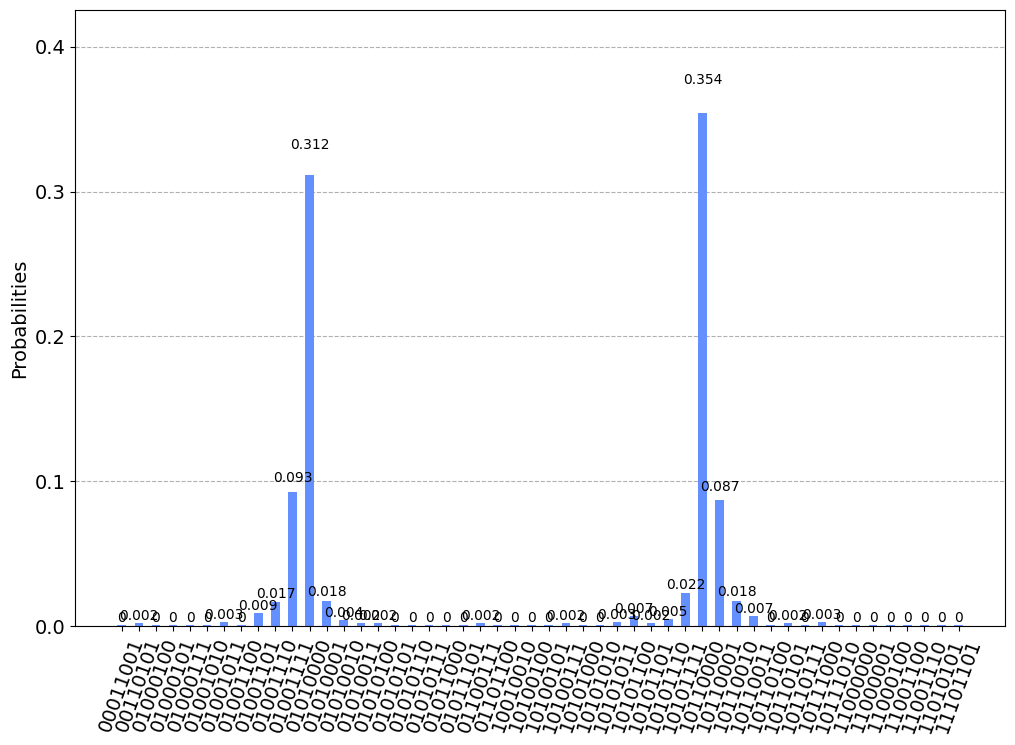

In [16]:
# Implementing QASM Simulator ~ 12-minute runtime
backend = BasicAer.get_backend("qasm_simulator")
qc_phase_tr = transpile(qc_phase, backend)
phase_job = execute(qc_phase_tr, backend)
phase_counts = phase_job.result().get_counts()
plot_histogram(phase_counts, figsize=(16,8))

# Saved Experiments Data

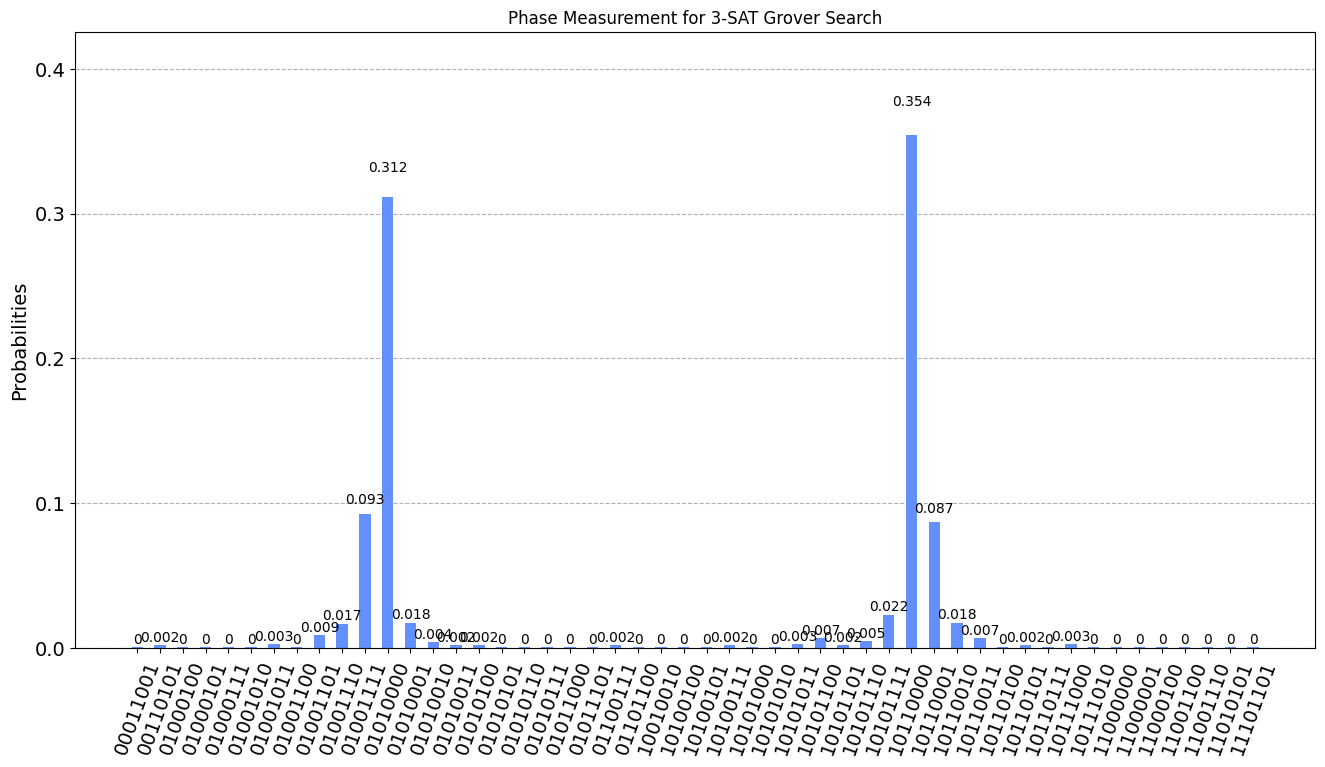

In [2]:
# Saved phase experiment data

phase_counts_saved = {'01010000': 319, '10110000': 363, '10110001': 89, '10101111': 23, '10110011': 7, '01001110': 17, '01001111': 95, '10110010': 18, 
                        '01001101': 9, '01010001': 18, '01011000': 1, '10110100': 1, '10101110': 5, '01010100': 2, '01001011': 3, '10100100': 1, 
                        '11001100': 1, '10111010': 1, '01010110': 1, '10101100': 7, '01010011': 2, '01010010': 4, '00011001': 1, '10110101': 2, 
                        '10111000': 3, '11001110': 1, '10100101': 1, '01100111': 2, '10101101': 2, '01000100': 1, '01010111': 1, '01001010': 1, 
                        '01000101': 1, '11000100': 1, '00110101': 2, '01001100': 1, '11000000': 1, '10101010': 1, '10101011': 3, '01101100': 1, 
                        '01010101': 1, '10010010': 1, '01000111': 1, '10100111': 2, '11010101': 1, '10101000': 1, '01011101': 1, '10110111': 1, 
                        '11101101': 1, '11000001': 1}

plot_histogram(phase_counts_saved, figsize=(16,8), title="Phase Measurement for 3-SAT Grover Search")

## Results post-processing

The histogram counts show that there are two modes centered at $0101\ 0000$ and $1011\ 0000$. These correspond to two eigenvalues of the Grover iteration.

To calculate the number of solutions, $M$, we realize that the inverse Fourier Transform would ouput:

$\begin{equation}
\text{measure} = \dfrac{2^t \theta}{2\pi} \rightarrow \theta = \dfrac{2 \pi \times \text{measure}}{2^t}
\end{equation}$

The measure is the integer form of the binary measurement $\left(80\right.$ and $176$ respectively $\left.\!\!\right)$ and $\theta$ is the angle of rotation caused by the Grover iteration.

After getting $\theta$, we can calculate $M = N \times \sin^2{\left(\theta/2\right)}$.

In [36]:
# Calculating M - number of solutions

# Getting one of the modes of measurement
counts_arr = np.array(list(phase_counts.values()))
maxind = counts_arr.argmax()

print("Most probable state is: " + str(list(phase_counts.keys())[maxind]))

Most probable state is: 10110000


In [33]:
# Converting to decimal integer form
measured_int = int("10110000", 2)
# Theta (grover iteration angle)
theta = 2 * np.pi * measured_int/(2**readout)

print("The phase is: " + str(theta))

4.319689898685965

The angle here actually reflects the number of non-solutions to the circuit. This is because our diffuser $U_{diff}$ was implemented with a global phase of $-1$. Usually this would not matter, but because of the controlled Grover iterations in phase estimation, it does. We fix this by subtracting the calculation of $M$ from $N$ to find the number of solutions.

In [37]:
# Number of solutions for the 3-SAT problem
solutions = np.sin(theta/2)**2 * 2**nbvar  # Calculate M (in this case, the number of nonsolutions)
solutions = 2**4 - solutions  # Subtraction N = 2**n from M (to get number of solutions)

print( str(round(solutions)) + " solutions")

5

### Grover Search of the SAT-3 Problem

Now that we have found our SAT problem has 5 solutions, we can build the search algorithm with the appropriate number of Grover iterations. This number should be

$\begin{equation}
R = \frac{\pi}{4} \sqrt{\frac{N}{M}} = \frac{\pi}{4} \sqrt{\frac{16}{5}} = 1.4 \rightarrow 1
\end{equation}$

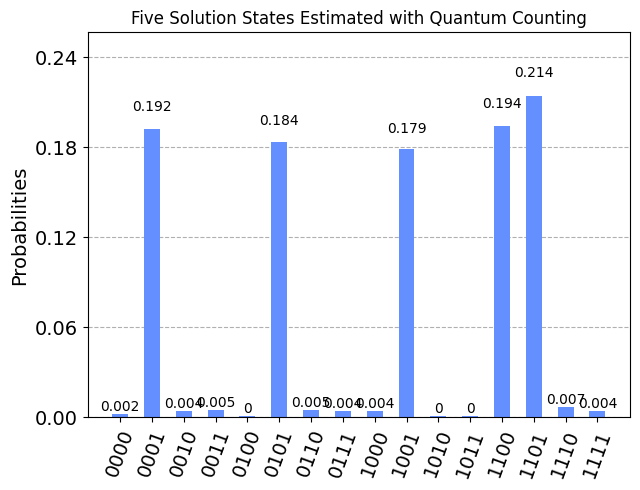

In [43]:
# Grover search circuit execution
search = QuantumCircuit(nbvar, nbvar)
search.h(range(search.num_qubits)) # Initial Hadamards
search.append(G, range(search.num_qubits)) # One Grover Iteration
search.measure(range(nbvar), range(nbvar)) # Measurement

tr_search = transpile(search, backend)
search_job = execute(tr_search, backend)
search_result = search_job.result() # executed circuit
search_counts = search_result.get_counts() # counts of each measurement

plot_histogram(search_counts, title="Five Solution States Estimated with Quantum Counting")

# Extra: Retrying the Phase Estimation

Everything beyond this point was testing and troubleshooting using previously known numbers of solutions (from the multiple solution Grover code). This was used to verify that the counting algorithm worked as intended.

Here, we set the probability of failure $\varepsilon=\frac{1}{6}$, such that the number of qubits needed for success and $5$-qubit accuracy is:

$ \begin{equation}
t = 5 + \left\lceil \log \left( 2 + \frac{6}{2} \right) \right\rceil = 5 + \left\lceil 2.32 \right\rceil = 8
\end{equation} $

In [104]:
# Creating the first quantum register with 8 qubits and the classical readout register

# Specify number of readout qubits
readout = 8

# Specify readout registers
controls = QuantumRegister(readout,"controls")
phase_result = ClassicalRegister(readout,"phase_result")

# Creating the second quantum register with 4 qubits
targets = QuantumRegister(4, "targets")

### From the multi-solution code

In [105]:
num_qubits_db = 4
qdb = QuantumRegister(num_qubits_db, "q")

# We have the option to mark 0-15 as solutions.

grover_solutions = [2, 3, 8, 15]
grover_solutions_bin = [(4 - len(bin(index)[bin(index).rfind("b") + 1:]))  *  "0"
                       + bin(index)[bin(index).rfind("b") + 1:] for index in grover_solutions]

print(grover_solutions_bin)

['0010', '0011', '1000', '1111']


In [106]:
# Oracle -- Marking the Solutions

# We mark the solution based on symmetric X gates to all the qubits where the solution has a zero, 
# followed by a multi-controlled NOT on the last qubit

# Zero Locations
zero_loc_2 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[0][::-1][digit] == "0"]
zero_loc_3 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[1][::-1][digit] == "0"]
zero_loc_8 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[2][::-1][digit] == "0"]
zero_loc_15 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[3][::-1][digit] == "0"]

# solution 2
orac_2 = QuantumCircuit(qdb)
orac_2.x(zero_loc_2)   
orac_2.h(qdb[-1])
orac_2.mcx(qdb[0:-1], qdb[-1])
orac_2.h(qdb[-1])
orac_2.x(zero_loc_2)

# solution 3
orac_3 = QuantumCircuit(qdb)
orac_3.x(zero_loc_3) 
orac_3.h(qdb[-1])
orac_3.mcx(qdb[0:-1], qdb[-1])
orac_3.h(qdb[-1])
orac_3.x(zero_loc_3)

# solution 8
orac_8 = QuantumCircuit(qdb)
orac_8.x(zero_loc_8)
orac_8.h(qdb[-1])
orac_8.mcx(qdb[0:-1], qdb[-1])
orac_8.h(qdb[-1])
orac_8.x(zero_loc_8)

# solution 15
orac_15 = QuantumCircuit(qdb)
orac_15.h(qdb[-1])
orac_15.mcx(qdb[0:-1], qdb[-1])
orac_15.h(qdb[-1])

In [107]:
# For multiple solutions we combine the oracle's markings for each solution
orac_2_sol = orac_2.compose(orac_3)
orac_3_sol = orac_2_sol.compose(orac_8)
orac_4_sol = orac_3_sol.compose(orac_15)

In [ ]:
# Diffuser: Amplifying the state

# We apply the unitary that flips the states about the mean amplitude
qc_diff = QuantumCircuit(qdb)
qc_diff = diffuser(qc_diff)

In [109]:
# Multi - Solution Grover Iteration
G = orac_3_sol.compose(qc_diff)
G.to_gate(label= "G")
cG = G.control(1, "G")

In [ ]:
# Combining all registers into a quantum circuit
qc_phase = QuantumCircuit(controls, qdb, phase_result)

# Initial Hadamards
qc_phase.h(controls[0:])
qc_phase.h(qdb[0:])

repetitions = 1
for counting_qubit in range(readout):
    list = [controls[counting_qubit]] + qdb[0:]
    for i in range(repetitions):
        qc_phase.append(cG, list)
    repetitions *= 2

qc_phase.barrier()

In [ ]:
# The Inverse qc_QFT for the first register
qc_QFT = QuantumCircuit(controls)
qc_QFT = iQFT(qc_QFT)

In [ ]:
# Combined Grover and inverse Fourier Tranform
qc_phase.append(iQFT, controls)
qc_phase.barrier()

# Measurement of First Register
qc_phase.measure(controls[0:],range(readout))
qc_phase.draw(fold=1500)

In [ ]:
# Implementing QASM Simulator
backend = BasicAer.get_backend("qasm_simulator")

qc_phase_tr = transpile(qc_phase, backend)
phase_job = execute(qc_phase_tr, backend)
phase_counts = phase_job.result().get_counts()
plot_histogram(phase_counts, figsize=(16,8), title="Multiple Solutions Phase Estimation")

In [118]:
# Post processing the number of solutions

# Likeliest occurrence phase calculation
first_high = int(0b01011100)/2**8
theta = (first_high * 2 * np.pi)

print("Likeliest phase readout is: " + str(theta))

0.359375 0.35546875 0.64453125 0.640625


In [120]:
# Number of solutions for the already known 3-solution grover search
no_solutions = np.sin(theta/2)**2 * (2**4)
no_solutions = 2**4 - no_solutions

print(str(round(no_solutions)) + "solutions")

3